# Scale to large numbers of qubits

In quantum computing, utility-scale work is crucial for making progress in the 
field . Such workrequires requires computations to be done o a much larger scale;
working with circuits that might use over 100 qubits and over 1000 gates. This example demonstrates how you can accomplish utility-scale work on IBM QPUs by creating and analyzing a 100-qubit GHZ state. It uses the Qiskit patterns workflow and ends by measuring the expectation value <  Z<sub>0</sub>Z<sub>i</sub>  > for each qubit.

# Step 1. Map the problem

Write a function that returns a QuantumCircuit that prepares an n-qubit GHZ state
(essentially an extended Bell state), then use that frnction to prepadre a 100-qubit GHZ state and collect the observables sto be measured.


In [5]:
from qiskit import QuantumCircuit

def get_qc_for_n_qubit_GHZ_state(n: int) -> QuantumCircuit:
    """ This function will create a qiskit.QuantumCircuit (qc) for an n-qubit GHZ state. 

    Args:
        n (int): Number of qubits in the n-qubit GHZ state

    Returns:
        QuantumCircuit: Quantum circuit that generat the n-qubit GHZ state, assuming all qubits start in the 0 state
    """    

    if isinstance(n, int ) and n >= 2:
        qc = QuantumCircuit(n)
        qc.h(0)
        for i in range(n - 1):
            qc.cx(i, i + 1)
    else:
        raise Exception("n is not a valid input")
    return qc

# Create a new circuit with two qubits (first argument) and two classical bits (second argument)
n = 100
qc = get_qc_for_n_qubit_GHZ_state(n)


Next, map to the operators of interest. This example uses the ZZ operators between qubits to examine the behavior as they get farther apart. Increasingly inaccurate (corrupted) expectation values between distant qubits would reveal the level of noise present.

In [6]:
from qiskit.quantum_info import SparsePauliOp
# ZZII....II, ZIZI...III, ..., ZIII...IZ
operator_strings = [
    "Z" + "I" * i + "Z" + "I" * (n - 2 - i) for i in range(n - 1)
]
print(operator_strings)
print(len(operator_strings))

operators = [SparsePauliOp(operator) for operator in operator_strings]




['ZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII

## Step 2. Optimize the problem for execution on quantum hardware

The followin code transforms the circuit and observables to match the backend's
ISA. It requires that you have already saved your crecentdials

In [7]:
from qiskit_ibm_runtime import QiskitRuntimeService 
QiskitRuntimeService.delete_account()

QiskitRuntimeService.save_account(
    channel="ibm_cloud",
    token="QDcOPHdQw2So98jLrsy7gjR-hnNa6oPDZ4sPHV0bxBW1",
    instance="instance_satya",
    overwrite=True
)

In [ ]:
from qiskit.transpiler import generate_preset_pass_manager


service = QiskitRuntimeService()

backend = service.least_busy(
    simulator=False, operational=True, min_num_qubits=100
)
pm = generate_preset_pass_manager(optimization_level=1, backend=backend)

isa_circuit = pm.run(qc)
isa_operators_list = [op.apply_layout(isa_circuit.layout) for op in operators]


# Step 3. Execute on hardware

Submit the job and enable error suppresion by using a technique to reduce errors called *dynamical decoupling*. The resilience level specifies how much resilience to build against errors. Higher levels generate more accurate results, at the expense of longer processing times.

In [9]:
from qiskit_ibm_runtime import EstimatorOptions
from qiskit_ibm_runtime import EstimatorV2 as Estimator

options = EstimatorOptions()
options.resilience_level = 1
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = "XY4"

# Create an Estimator object
estimator = Estimator(backend, options=options)


In [11]:
# Submit the circuit to Estimator
job = estimator.run([(isa_circuit, isa_operators_list)])
job_id = job.job_id()
print(job_id)


d1pda095jdrc73dsiig0


## Step 4. Post-process results

After the job completes, plot the results and notice that < Z<sub>0</sub>Z<sub>i</sub> >decreases with increasing i, even though in an ideal simulation all < Z<sub>0</sub>Z<sub>i</sub> > should be 1.


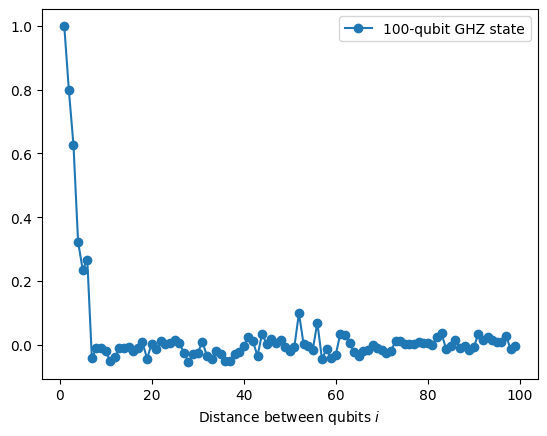

In [12]:
import matplotlib.pyplot as plt
from qiskit_ibm_runtime import QiskitRuntimeService

# data
data = list(range(1, len(operators) + 1)) # Distance between the Z operators
result = job.result() [0]
values = result.data.evs  # Expectation value at each Z operator.
values = [
    v / values[0] for v in values
] # Normalize the expectation values to evaluate how they decay with distance.

# plotting graph
plt.plot(data, values, marker="o", label="100-qubit GHZ state")
plt.xlabel("Distance between qubits $i$")
plt.ylabel=(r"$\langle Z_i Z_0 \rangle / \langle Z_1 Z_0 \rangle $")
plt.legend()
plt.show()
  


The previous plot shows that as the distance between qubits increases, the signal decays because of the presence of noise.